In [1]:
from src.utils import data_load
import pandas as pd
import matplotlib.pyplot as plt
from src.s3_utils import pandas_from_csv_s3
import re
import datetime
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import pickle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kfkxoj8c because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
keys = {'oura_sleep', 'birth'}
data = data_load(data_keys=keys, wave=5)

In [3]:
# oura_list = ['score_total', 'hr_average', 'temperature_delta', 'rmssd']
oura_list = ['awake', 'bedtime_end', 'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta', 'breath_average', 'deep', 'duration', 'efficiency', 'hr_average', 'hr_lowest', 'is_longest', 'light', 'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id', 'rem', 'restless', 'rmssd', 'score', 'score_alignment', 'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency', 'score_rem', 'score_total', 'temperature_delta', 'temperature_deviation', 'temperature_trend_deviation', 'timezone', 'total']
birth_list = ['user_id', 'birth_date', 'birth_scheduled', 'birth_gestage']

In [4]:
oura_df = data['oura_sleep'][['user_id', 'date'] + oura_list]
oura_df['date'] = pd.to_datetime(oura_df['date'])
birth_df = data['birth'][birth_list]
birth_df['birth_date'] = pd.to_datetime(birth_df['birth_date'])

In [5]:
len(birth_df['user_id'].unique())

245

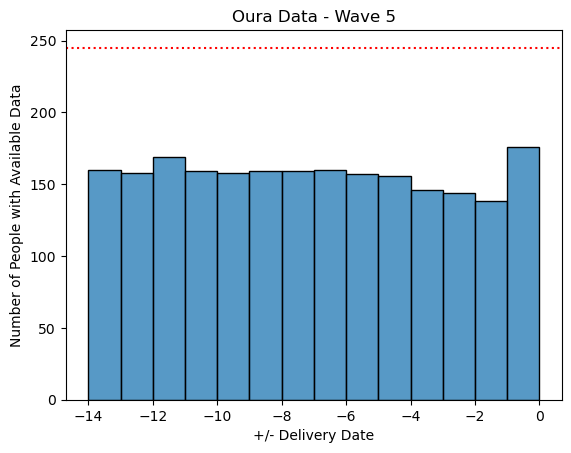

In [6]:
def plot_data_frequency(birth_df, data_df, start=None, end=None, title=None):
    frequency = []
    for uid in birth_df['user_id'].unique():
        df = data_df.loc[data_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
            if start != None:
                df = df[(df['date'] >= birth_date + pd.to_timedelta(-start, unit='d'))]
            if end != None:
                df = df[(df['date'] <= birth_date + pd.to_timedelta(end, unit='d'))]
            df = df.dropna()
            df['int_time'] = df['date'].apply(lambda x: (x - birth_date).days)
            if len(df['int_time'].unique()) == len(df):
                frequency.extend(df['int_time'].tolist())
    bin_num = max(frequency) - min(frequency)
    sns.histplot(data=np.array(frequency), bins=bin_num)
    plt.xlabel('+/- Delivery Date')
    plt.ylabel('Number of People with Available Data')
    plt.axhline(y=len(birth_df), color='r', linestyle=':')
    if title != None:
        plt.title(title)
plot_data_frequency(birth_df, oura_df, start=14, end=0, title='Oura Data - Wave 5')

In [7]:
processed_data = defaultdict(list,{ k:[] for k in oura_list + ['user_id'] })
for uid in birth_df['user_id'].unique():
    df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
    if len(df) > 0:
        birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
        df = df[(df['date'] >= birth_date + pd.to_timedelta(-60, unit='d'))]
        df = df[(df['date'] <= birth_date + pd.to_timedelta(0, unit='d'))]
        df = df.dropna()
        if len(df) == 60:
            processed_data['user_id'].append(uid)
            for col in oura_list:
                processed_data[col].append(df[col].tolist())

In [8]:
len(processed_data['user_id'])

24

In [9]:
for uid in processed_data['user_id']:
    newpath = f'/repos/Delivery-Readiness/data/bump_user_{int(uid)}' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

In [10]:
for col in oura_list:
    for i in range(len(processed_data[col])):
        uid = processed_data['user_id'][i]
        with open(f'/repos/Delivery-Readiness/data/bump_user_{int(uid)}/{col}_0.pkl', 'wb') as handle:
            pickle.dump(np.array([processed_data[col][i]]).T, handle)